## PUMPED HYDRO DISPATCH MODEL (NO DROUGHT)

In [14]:
import cvxpy as cp
import numpy as np
import gurobipy

# Print the installed solver to see if GUROBI is installed correctly
print("Current installed solvers: ", cp.installed_solvers())

Current installed solvers:  ['ECOS', 'ECOS_BB', 'GUROBI', 'OSQP', 'SCIPY', 'SCS']


In [102]:
## Parameters
T = 5 # number of hours
price = np.array([80, 50, 50, 70, 80]) # price of electricity
etah = 0.8 #pumping efficiency 
etap = 1  #discharge efficiency
alpha = np.array([.2, .3, .8, .6, .3]) # solar radiation capacity
nevap = 0.01

S = 1000 # solar capacity (MW)
PMax = 500  # maximum generation (MW)
Emin = 50 # minimum reservoir capacity
Emax = 500 # maximum reservoir capacity
e0   = 200  # initial reservoir state

LOAD = np.array([450,525,765,525, 400]);

In [103]:
## Variables
p = cp.Variable((T), nonneg = True)   # hydropower generation (discharge)
h = cp.Variable((T), nonneg = True)   # hydropower recharge
g = cp.Variable((T), nonneg = True)   # electricity import
x = cp.Variable((T), nonneg = True)   # electricity export
eU = cp.Variable((T), nonneg = True)  # upper reservoir state
eL = cp.Variable((T), nonneg = True)  # upper reservoir state

$\max Profit = \sum_{t \in N}\lambda_t(x_t - g_t)$

In [104]:
obj = cp.Maximize(price@(x-g))

$g_t + \alpha_tS + p_t = D_t + x_t + h_t$

In [105]:
# Initialize an empty constraint set
con_set_1 = []  

# power balance constraint, supply equals demand
con_set_1.append(g + S*alpha + p == LOAD + x + h )

$0 \leq p_t \leq P_{max}$

$0 \leq h_t \leq \eta^h\alpha_tS$

$E_{min} \leq e_{U,L,t} \leq E_{max}$

In [106]:
# use a for loop to define the unit constriant over each time period
for t in range(T):  # go through each period
        con_set_1.append(p[t] <= PMax)  # maximum generation limits
        con_set_1.append(p[t] >= 0)  # minimum generation limits
        
        con_set_1.append(h[t] <= etah*alpha[t]*S)  # maximum pumping limits
        con_set_1.append(h[t] >= 0)  # minimum pumping limits
        
        con_set_1.append(eU[t] <= Emax)  # maximum pumping limits
        con_set_1.append(eU[t] >= Emin)  # minimum pumping limits
        con_set_1.append(eL[t] <= Emax)  # maximum pumping limits
        con_set_1.append(eL[t] >= Emin)  # minimum pumping limits

$$e_{U,t} = \eta^hh_t - \eta^pp_t + (1 - \eta^{evap})e_{U,t-1}$$
$$e_{L,t} = \eta^pp_t - \eta^hh_t + (1 - \eta^{evap})e_{L,t-1}$$

In [107]:
for t in range(T):  
        if t==0:
            # for the first period, check with initial reservoir status
            con_set_1.append( eU[0] == etah*h[0]-etap*p[0] + (1-nevap)*e0) # upper
            con_set_1.append( eL[0] == etap*p[0]-etah*h[0] + (1-nevap)*e0) # lower
        else:
            con_set_1.append( eU[t] == etah*h[t]-etap*p[t] + (1-nevap)*eU[t-1]) # upper
            con_set_1.append( eL[t] == etap*p[t]-etah*h[t] + (1-nevap)*eL[t-1]) # lower

In [108]:
prob1 = cp.Problem(obj, con_set_1)
prob1.solve(solver = "GUROBI")
prob1.solve();

In [109]:
print("\n Total operating cost: %.1f" % obj.value)


 Total operating cost: -15973.3


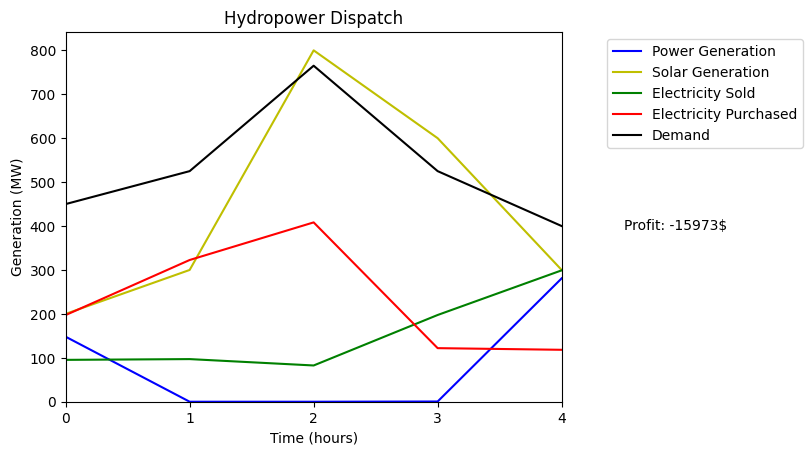

In [110]:
## Plots

# Plot generator status results 
import matplotlib.pyplot as plt

# Time axis
t = np.linspace(0, T-1, T) 

plt.plot(t, p.value, label='Power Generation', color='b')
plt.plot(t, S*alpha, label='Solar Generation', color='y')
plt.plot(t, x.value, label='Electricity Sold', color='g')
plt.plot(t, g.value, label='Electricity Purchased', color='r')
plt.plot(t, LOAD, label='Demand', color='black')

# Adding labels and title
plt.xlim(0,T-1)
plt.xticks(t)  # Only integer x ticks
plt.ylim(0, max(LOAD)*1.1)
plt.xlabel('Time (hours)')
plt.ylabel('Generation (MW)')
plt.title(f'Hydropower Dispatch')

# Adding a legend
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

plt.text(4.5, 400, f'Profit: {round(obj.value)}$', verticalalignment='center', horizontalalignment='left')

# Display the plot
plt.show()

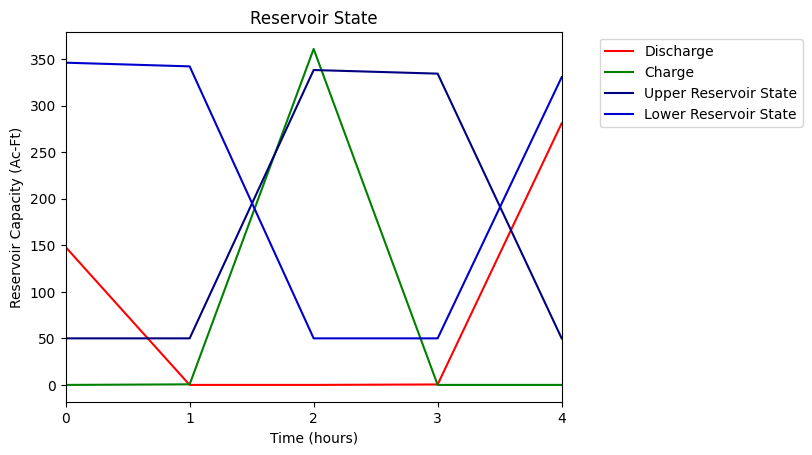

In [111]:
plt.plot(t, p.value, label='Discharge', color='r')
plt.plot(t, h.value, label='Charge', color='g')
plt.plot(t, eU.value, label='Upper Reservoir State', color='navy')
plt.plot(t, eL.value, label='Lower Reservoir State', color='mediumblue')

# Adding labels and title
plt.xlim(0,T-1)
plt.xticks(t)  # Only integer x ticks
#plt.ylim(0, max(LOAD)*1.1)
plt.xlabel('Time (hours)')
plt.ylabel('Reservoir Capacity (Ac-Ft)')
plt.title(f'Reservoir State')

# Adding a legend
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

# Display the plot
plt.show()